In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import matplotlib.pyplot as plt

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [7]:
#install scikit learn multiflow
!pip install -U scikit-multiflow

In [8]:
from skmultiflow.trees import HoeffdingTree

In [9]:
#instancia modelo 
global tree 
tree = HoeffdingTree()

/opt/conda/lib/python3.7/site-packages/skmultiflow/trees/hoeffding_tree.py:35: FutureWarning: 'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  "The old name will be removed in v0.7.0", category=FutureWarning)


Conteúdo teórico

Link paper: http://pure-oai.bham.ac.uk/ws/files/58197088/Class_Imbalance.pdf

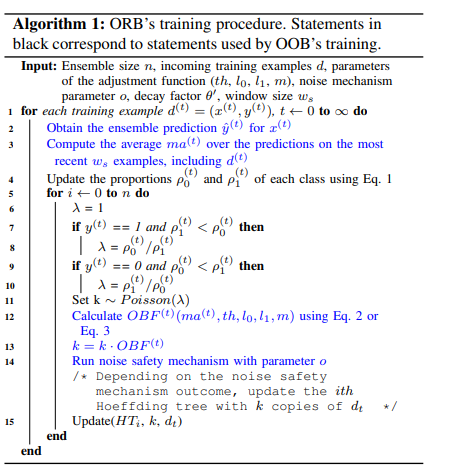

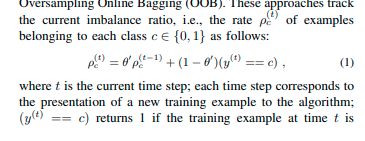

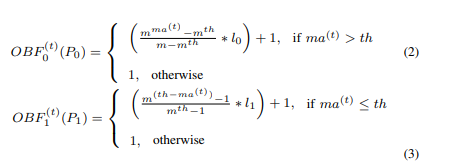

In [10]:
import os

df_all_projects = pd.read_csv('/kaggle/input/all-projects/all_projects_with_dates.csv',sep=";")

df_tomcat = df_all_projects[df_all_projects["repository_name"] == "tomcat"]

df_tomcat.reset_index(drop=True)
df_tomcat[["author_date_unix_timestamp"]] = df_tomcat[["author_date_unix_timestamp"]].apply(pd.to_numeric)

#opr 0 eu vou dizer que eh para teste e opr 1 eu vou dizer que eh pra treino
df_tomcat["opr"] = 0

timestamp_day = 86400

def add_defect_ind_train_data(latency_in_days):
    global df_tomcat
    
    df_tomcat_defect = df_tomcat[df_tomcat["contains_bug"] == True]
    
    for index, row in df_tomcat_defect.iterrows():
        
        if(round(row["days_to_first_fix"]) <= latency_in_days):
            row1 = row.copy()
            row1["author_date_unix_timestamp"] = row1["author_date_unix_timestamp"] + round(row["days_to_first_fix"] * timestamp_day)
            row["opr"] = 1
        
            df_tomcat = df_tomcat.append(row1, ignore_index = True)
        else:
            #training instance with correct label
            row1 = row.copy()
            row1["author_date_unix_timestamp"] = row["author_date_unix_timestamp"] + round(row["days_to_first_fix"] * timestamp_day)
            row1["opr"] = 1
            
            #training instance with wrong label (noise)
            row2 = row.copy()
            row2["author_date_unix_timestamp"] = row["author_date_unix_timestamp"] + round(latency_in_days * timestamp_day)
            row2["opr"] = 1
            row2["contains_bug"] = False
        
            df_tomcat = df_tomcat.append(row1, ignore_index = True)
            df_tomcat = df_tomcat.append(row2, ignore_index = True)
            
def add_clean_train_data(latency_in_days):
    global df_tomcat

    df_tomcat_clean = df_tomcat[df_tomcat["contains_bug"] == False]

    for index, row in df_tomcat_clean.iterrows():

        row1 = row.copy()
        row1["author_date_unix_timestamp"] = row1["author_date_unix_timestamp"] + round(latency_in_days * timestamp_day)
        row1["opr"] = 1
            
        df_tomcat = df_tomcat.append(row1, ignore_index = True)
                
    
    print(len(df_tomcat))

    
latency_in_days = 90
add_defect_ind_train_data(latency_in_days)   
add_clean_train_data(latency_in_days)

df_tomcat = df_tomcat.drop(columns=["repository_name","days_to_first_fix"])
df_tomcat = df_tomcat.sort_values(by=['author_date_unix_timestamp'], ascending=True)
df_tomcat = df_tomcat.reset_index(drop=True)
df_tomcat['contains_bug'] = df_tomcat["contains_bug"].astype(int)

print(df_tomcat.head())

#nesse ponto, a base de dados tem que ser tratada como uma data stream de forma que os exemplos com 
#opr = 0 são testados pelo classificador e os com opr = 1 sao usados para treinar o classificador.
#o classificador vai testar e treinar de forma incremental


44006
   author_date_unix_timestamp    fix  contains_bug   ns    nd     nf  \
0                  1143467626  False             0  2.0  79.0  976.0   
1                  1143489078  False             0  1.0   1.0    1.0   
2                  1143528058  False             0  1.0   2.0   18.0   
3                  1143528343  False             0  1.0   1.0    2.0   
4                  1143528575  False             0  1.0   1.0    1.0   

   entrophy        la   ld     lt  ndev       age  nuc    exp      rexp  \
0  8.937692  264772.0  0.0    0.0   1.0  0.000000  0.0  487.5  0.000000   
1  0.000000       2.0  1.0  190.0   1.0  0.248287  1.0  976.0  5.027596   
2  3.816620    9872.0  0.0    0.0   1.0  0.000000  0.0    8.5  0.000000   
3  0.950956      27.0  0.0    0.0   1.0  0.000000  0.0   18.5  0.000000   
4  0.000000    1025.0  0.0    0.0   1.0  0.000000  0.0   20.0  0.000000   

    sexp  opr  
0  974.0    0  
1  975.0    0  
2   17.0    0  
3    1.0    0  
4   18.0    0  


In [11]:
def ensemble_predict(n,X):
    return tree.predict(X)

In [12]:
def compute_mean(preds, w):
    mean = 0
    last_w = preds[-w:]
    
    mean = sum(last_w)/w
    return mean

In [13]:
def calcular_obf(ma_t, m, th, l_0, l_1):
    if(ma_t > th):
        p_0 = ( ((m**ma_t - m**th)/(m - m**th))*l_0) + 1
        p_1 = 1
    else:
        p_0 = 1
        p_1 = ( ((m**(ma_t - th) - 1)/(m**th - 1))*l_1) + 1
    return p_0, p_1

In [15]:

#n = emsemble size
#d = dataset
#n_f = número de features
# (th, l_0, l_1, m) = parametros de ajuste da função
#o = parâmetro do mecanismo de ruído
#theta = fator de decaimento
#w = tamanho da janela
#p_0 = proporção da classe 0 
#p_1 = proporção da classe 1
def orb(n, d, n_f, th, l_0, l_1, m, o, theta, w, p_0, p_1):
    preds = []
    correctness_dist = []
    nb_iters = 0;

    for index,d_t in d.iterrows():

        X = np.array([d_t.drop(['contains_bug']).to_numpy()])
        #print(X)
        y = np.array([d_t['contains_bug']])
        #print(y)
        if d_t['opr'] == 0: 
            y_pred = ensemble_predict(n,X)
            preds.append(y_pred)
            #checa a corretude da predição
            if y == y_pred:                
                correctness_dist.append(1)
            else:
                correctness_dist.append(0)
            nb_iters = nb_iters + 1
        #computa a média móvel
        ma_t = compute_mean(preds, w)
        #atualizar proporções
        if y == 0:
            p_0 = theta*p_0 + (1 - theta)
        else:
            p_1 = theta*p_1 + (1 - theta)
        
        for i in range(0,n):
            lambda_var = 1
            if y == 1 and p_1 < p_0:
                lambda_var = p_0 / p_1
            if y == 0 and p_0 < p_1:
                lambda_var = p_1 / p_0
            obf_p_0, obf_p_1 = calcular_obf(ma_t, m, th, l_0, l_1)
            k = 4
        if d_t['opr'] == 1:
            tree.partial_fit(X, y)
        
            
    time = [i for i in range(1, nb_iters)]
    accuracy = [sum(correctness_dist[:i])/len(correctness_dist[:i]) for i in range(1, nb_iters)] 
    plt.plot(time, accuracy)


FIM


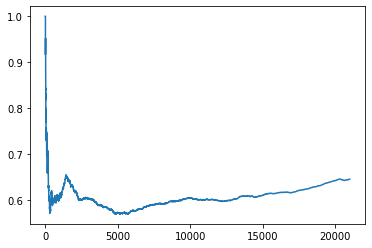

In [16]:
#Fluxo
df_tomcat.name = 'Tomcat'
orb(3,df_tomcat,16,0.5,1,1,3,0.5,1,5,0.5,0.5)
print('FIM')